### Model tranining and inference

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import time
import os
from sklearn.model_selection import train_test_split

# Ensure TensorFlow uses CPU for inference later
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU for inference

# Load ShipsNet dataset from JSON
def load_shipsnet(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images = np.array(data['data']).reshape(-1, 80, 80, 3) / 255.0  # Normalize to [0, 1]
    labels = np.array(data['labels'])
    return images, labels

# Build a shallow CNN
def create_shallow_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(80, 80, 3)),
        tf.keras.layers.Conv2D(16, (3, 3), padding='same', name='conv1'),
        tf.keras.layers.ReLU(name='relu1'),
        tf.keras.layers.MaxPooling2D((2, 2), name='pool1'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', name='conv2'),
        tf.keras.layers.ReLU(name='relu2'),
        tf.keras.layers.MaxPooling2D((2, 2), name='pool2'),
        tf.keras.layers.Flatten(name='flatten'),
        tf.keras.layers.Dense(64, name='dense1'),
        tf.keras.layers.ReLU(name='relu3'),
        tf.keras.layers.Dense(2, activation='softmax', name='output')
    ])
    return model

# Custom inference function to measure layer times
def run_inference_with_timing(model, image):
    timings = {}
    input_tensor = tf.convert_to_tensor(image[None, ...], dtype=tf.float32)
    
    # Extract layers
    conv1 = model.get_layer('conv1')
    relu1 = model.get_layer('relu1')
    pool1 = model.get_layer('pool1')
    conv2 = model.get_layer('conv2')
    relu2 = model.get_layer('relu2')
    pool2 = model.get_layer('pool2')
    flatten = model.get_layer('flatten')
    dense1 = model.get_layer('dense1')
    relu3 = model.get_layer('relu3')
    output = model.get_layer('output')

    # Forward pass with timing
    start = time.time()
    x = conv1(input_tensor)
    timings['conv1'] = time.time() - start

    start = time.time()
    x = relu1(x)
    timings['relu1'] = time.time() - start

    start = time.time()
    x = pool1(x)
    timings['pool1'] = time.time() - start

    start = time.time()
    x = conv2(x)
    timings['conv2'] = time.time() - start

    start = time.time()
    x = relu2(x)
    timings['relu2'] = time.time() - start

    start = time.time()
    x = pool2(x)
    timings['pool2'] = time.time() - start

    start = time.time()
    x = flatten(x)
    timings['flatten'] = time.time() - start

    start = time.time()
    x = dense1(x)
    timings['dense1'] = time.time() - start

    start = time.time()
    x = relu3(x)
    timings['relu3'] = time.time() - start

    start = time.time()
    x = output(x)
    timings['output'] = time.time() - start

    total_time = sum(timings.values())
    timings['total'] = total_time
    return timings

def main():
    # Load dataset 
    json_path = 'shipsnet.json'  
    images, labels = load_shipsnet(json_path)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Convert labels to categorical
    y_train = tf.keras.utils.to_categorical(y_train, 2)
    y_test = tf.keras.utils.to_categorical(y_test, 2)

    # Create and compile model
    model = create_shallow_cnn()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train with Metal (MPS) if available
    if tf.config.list_physical_devices('MPS'):
        print("Training with Metal (MPS)...")
        with tf.device('/device:MPS:0'):
            model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
    else:
        print("MPS not available, training on CPU...")
        model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

    # Save model
    model.save('shipsnet_model.h5')

    # Select 20 random test images for inference
    np.random.seed(42)
    indices = np.random.choice(X_test.shape[0], 20, replace=False)
    test_images = X_test[indices]

    # Run inference on CPU and collect timings
    all_timings = []
    for i, img in enumerate(test_images):
        print(f"Running inference on image {i+1}/20...")
        timings = run_inference_with_timing(model, img)
        timings['image_id'] = i
        all_timings.append(timings)

    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_timings)
    df = df[['image_id', 'conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2', 'flatten', 'dense1', 'relu3', 'output', 'total']]
    df.to_csv('inference_timings.csv', index=False)

    # Calculate and print average inference time
    avg_time = df['total'].mean()
    print(f"\nAverage inference time per image: {avg_time:.6f} seconds")

if __name__ == "__main__":
    main()

2025-02-23 18:00:32.568210: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-02-23 18:00:32.568590: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-23 18:00:32.568620: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1740330032.569369   52612 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740330032.570229   52612 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


MPS not available, training on CPU...
Epoch 1/5


2025-02-23 18:00:35.464660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8325 - loss: 0.4434 - val_accuracy: 0.9237 - val_loss: 0.1748
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9388 - loss: 0.1561 - val_accuracy: 0.9475 - val_loss: 0.1386
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9592 - loss: 0.1248 - val_accuracy: 0.9638 - val_loss: 0.1028
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9623 - loss: 0.0993 - val_accuracy: 0.9750 - val_loss: 0.0820
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9776 - loss: 0.0636 - val_accuracy: 0.9688 - val_loss: 0.1021


Running inference on image 1/20...
Running inference on image 2/20...
Running inference on image 3/20...
Running inference on image 4/20...
Running inference on image 5/20...
Running inference on image 6/20...
Running inference on image 7/20...
Running inference on image 8/20...
Running inference on image 9/20...
Running inference on image 10/20...
Running inference on image 11/20...
Running inference on image 12/20...
Running inference on image 13/20...
Running inference on image 14/20...
Running inference on image 15/20...
Running inference on image 16/20...
Running inference on image 17/20...
Running inference on image 18/20...
Running inference on image 19/20...
Running inference on image 20/20...

Average inference time per image: 0.053190 seconds


### Quantize (post training) and export to TFlite

In [3]:
import tensorflow as tf
import numpy as np
import json
import os

# Load ShipsNet dataset for representative data
def load_shipsnet(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images = np.array(data['data']).reshape(-1, 80, 80, 3) / 255.0  # Normalize to [0, 1]
    return images

# Generator for representative dataset
def representative_dataset_gen(images, num_samples=100):
    for i in range(min(num_samples, len(images))):
        yield [images[i:i+1].astype(np.float32)]  # Yield single image as batch of 1

def quantize_and_export_to_tflite(model_path, output_path, json_path):
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")

    # Load dataset for quantization calibration
    images = load_shipsnet(json_path)
    print(f"Loaded {len(images)} images for quantization.")

    # Convert to TFLite with INT8 quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Enable full integer quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.int8]  # Force INT8 weights
    converter.inference_input_type = tf.int8           # INT8 inputs
    converter.inference_output_type = tf.int8          # INT8 outputs
    
    # Provide representative dataset for activation quantization
    def rep_dataset():
        return representative_dataset_gen(images)
    converter.representative_dataset = rep_dataset

    # Convert the model
    tflite_model = converter.convert()
    print("Model successfully quantized and converted to TFLite.")

    # Save the TFLite model
    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Quantized TFLite model saved to {output_path}.")

    # Optional: Verify file size
    file_size = os.path.getsize(output_path) / 1024  # Size in KB
    print(f"TFLite model size: {file_size:.2f} KB")

def main():
    # Paths (adjust as needed)
    model_path = 'shipsnet_model.h5'      # From previous training
    tflite_path = 'shipsnet_quantized.tflite'
    json_path = 'shipsnet.json'          # Your dataset

    # Quantize and export
    quantize_and_export_to_tflite(model_path, tflite_path, json_path)

if __name__ == "__main__":
    main()

Model loaded successfully.
Loaded 4000 images for quantization.
INFO:tensorflow:Assets written to: /var/folders/ql/4_5wkdv130sbwn306v206qw40000gn/T/tmpso5p6v_c/assets


INFO:tensorflow:Assets written to: /var/folders/ql/4_5wkdv130sbwn306v206qw40000gn/T/tmpso5p6v_c/assets


Saved artifact at '/var/folders/ql/4_5wkdv130sbwn306v206qw40000gn/T/tmpso5p6v_c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  5258914000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258917648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258916112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258915536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258916496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258917072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5258915920: TensorSpec(shape=(), dtype=tf.resource, name=None)


/Users/mhamedazizbelkhiria/Documents/Dev/ships/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1740330278.934501   52612 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740330278.934747   52612 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-23 18:04:38.937746: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/ql/4_5wkdv130sbwn306v206qw40000gn/T/tmpso5p6v_c
2025-02-23 18:04:38.938334: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-23 18:04:38.938342: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/ql/4_5wkdv130sbwn306v206qw40000gn/T/tmpso5p6v_c
I0000 00:00:1740330278.953679   52612 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-

Model successfully quantized and converted to TFLite.
Quantized TFLite model saved to shipsnet_quantized.tflite.
TFLite model size: 811.88 KB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


## Inference conmparison

### laod data

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import json

# Load ShipsNet dataset
def load_shipsnet(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images = np.array(data['data']).reshape(-1, 80, 80, 3) / 255.0  # Normalize to [0, 1]
    labels = np.array(data['labels'])
    return images, labels

json_path = 'shipsnet.json'  # Adjust if needed
images, labels = load_shipsnet(json_path)

# Split into test set (20% as before)
from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Test set size: {X_test.shape[0]} images")

Test set size: 800 images


### Test on Non Quantised

In [6]:
# Load non-quantized model
non_quantized_model = tf.keras.models.load_model('shipsnet_model.h5')
print("Non-quantized model loaded.")

# Run inference
non_quantized_preds = non_quantized_model.predict(X_test)
non_quantized_preds_labels = np.argmax(non_quantized_preds, axis=1)

# Compute accuracy and confusion matrix
non_quantized_accuracy = accuracy_score(y_test, non_quantized_preds_labels)
non_quantized_cm = confusion_matrix(y_test, non_quantized_preds_labels)

print(f"Non-quantized model accuracy: {non_quantized_accuracy:.4f}")
print("Non-quantized confusion matrix:\n", non_quantized_cm)

Non-quantized model loaded.
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Non-quantized model accuracy: 0.9688
Non-quantized confusion matrix:
 [[588   3]
 [ 22 187]]


### Quantised

In [7]:
# Load quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='shipsnet_quantized.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare test data for INT8 input (scale from [0, 1] to [-128, 127])
input_scale, input_zero_point = input_details[0]['quantization']
X_test_quantized = (X_test / input_scale + input_zero_point).astype(np.int8)

# Run inference
quantized_preds = []
for i in range(X_test.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], X_test_quantized[i:i+1])
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    quantized_preds.append(output_data[0])

quantized_preds = np.array(quantized_preds)
output_scale, output_zero_point = output_details[0]['quantization']
quantized_preds_labels = np.argmax(quantized_preds, axis=1)  # Assuming INT8 outputs are class scores

# Compute accuracy and confusion matrix
quantized_accuracy = accuracy_score(y_test, quantized_preds_labels)
quantized_cm = confusion_matrix(y_test, quantized_preds_labels)

print(f"Quantized model accuracy: {quantized_accuracy:.4f}")
print("Quantized confusion matrix:\n", quantized_cm)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Quantized model accuracy: 0.9087
Quantized confusion matrix:
 [[544  47]
 [ 26 183]]


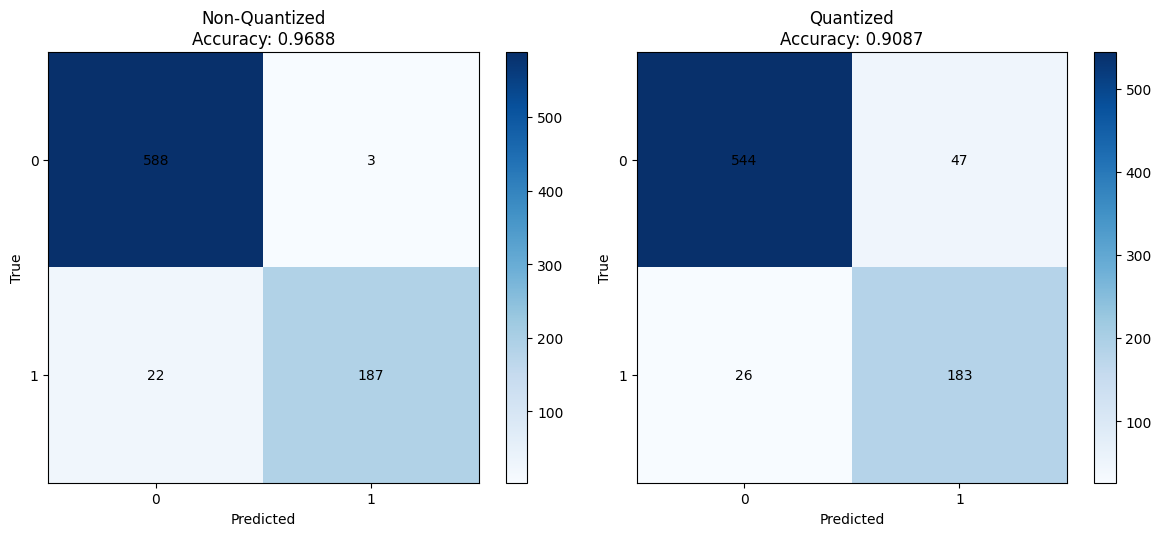


Accuracy Comparison:
Non-Quantized: 0.9688
Quantized: 0.9087
Accuracy Drop: 0.0600


In [8]:
# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Non-quantized
im1 = ax1.imshow(non_quantized_cm, interpolation='nearest', cmap='Blues')
ax1.set_title(f'Non-Quantized\nAccuracy: {non_quantized_accuracy:.4f}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
for i in range(2):
    for j in range(2):
        ax1.text(j, i, non_quantized_cm[i, j], ha='center', va='center', color='black')
fig.colorbar(im1, ax=ax1)

# Quantized
im2 = ax2.imshow(quantized_cm, interpolation='nearest', cmap='Blues')
ax2.set_title(f'Quantized\nAccuracy: {quantized_accuracy:.4f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
for i in range(2):
    for j in range(2):
        ax2.text(j, i, quantized_cm[i, j], ha='center', va='center', color='black')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Summary
print(f"\nAccuracy Comparison:")
print(f"Non-Quantized: {non_quantized_accuracy:.4f}")
print(f"Quantized: {quantized_accuracy:.4f}")
print(f"Accuracy Drop: {(non_quantized_accuracy - quantized_accuracy):.4f}")

### Test data for the docker container

In [9]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

# Load full dataset
def load_shipsnet(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    images = np.array(data['data']).reshape(-1, 80, 80, 3) / 255.0
    labels = np.array(data['labels'])
    return images, labels

json_path = 'shipsnet.json'  # Your full dataset
images, labels = load_shipsnet(json_path)

# Select 20 random samples
_, X_test, _, y_test = train_test_split(images, labels, test_size=20, random_state=42)

# Prepare data for JSON (flatten images back to 1D)
test_data = {
    'data': (X_test.reshape(20, -1) * 255.0).astype(np.uint8).tolist(),  # Un-normalize to 0-255
    'labels': y_test.tolist()
}

# Save to new JSON file
with open('shipsnet_20.json', 'w') as f:
    json.dump(test_data, f)
print("Saved 20 images to shipsnet_20.json")

Saved 20 images to shipsnet_20.json


In [2]:
import tf2onnx
import tensorflow as tf

# Load TFLite model
tflite_path = "shipsnet_quantized.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Convert to ONNX
model_proto, _ = tf2onnx.convert.from_tflite(
    tflite_path=tflite_path,
    input_names=[input_details[0]['name']],
    output_names=[output_details[0]['name']],
    opset=18,  # Latest opset as of Feb 2025
    output_path="~/dockers/shipsnet.onnx"
)
print("Converted to ONNX: ~/dockers/shipsnet.onnx")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
I0000 00:00:1740338274.643193  210802 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740338274.643514  210802 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Converted to ONNX: ~/dockers/shipsnet.onnx
